In [1]:
%matplotlib inline
import pdb, sys, os
sys.path.insert(0, './core/')

import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = [10, 5]

from functools import partial
from collections import defaultdict

np.set_printoptions(suppress=True, linewidth=120, precision=4)
pd.set_option('display.max_columns', 15)
pd.set_option('display.width', 1000)

In [2]:
# mnist data processing block
ENDIAN = 'big'
MAX_VAL = 255.0
MNIST_IMG_SIZE = (28,28)

def read_images(fname, down_sample):
    f = open(fname,'rb')
    assert( int.from_bytes(f.read(4),ENDIAN) == 2051 )
    N = int.from_bytes(f.read(4),ENDIAN)
    row_size = int.from_bytes(f.read(4),ENDIAN)
    col_size = int.from_bytes(f.read(4),ENDIAN)
    buf = f.read(N*row_size*col_size)
    data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32).reshape(N, row_size * col_size)
    f.close()

    # flatten the image and downsample a little bit, normalize to 0-1
    ret = []
    for row in data:
        img = row.reshape(row_size,col_size)

        if down_sample:
            img = block_reduce(img, (2,2), np.max)

        ret.append(img.flatten()/MAX_VAL)
    return np.array(ret)

def read_label(fname):
    f = open(fname,'rb')
    assert( int.from_bytes(f.read(4),ENDIAN) == 2049 )
    N = int.from_bytes(f.read(4),ENDIAN)
    buf = f.read(N)
    data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
    f.close()
    return data

mnist_dir = './data/digits/mnist/'
train_image = f'{mnist_dir}/train-images.idx3-ubyte'
train_label = f'{mnist_dir}/train-labels.idx1-ubyte'
test_image = f'{mnist_dir}/t10k-images.idx3-ubyte'
test_label = f'{mnist_dir}/t10k-labels.idx1-ubyte'


Xtr = read_images(train_image, False)
ytr = read_label(train_label)
Xte = read_images(test_image, False)
yte = read_label(test_label)

# stack all mnist data for training auto encoder
train_data = np.vstack([Xtr,Xte])
np.random.shuffle(train_data)


(70000, 784)


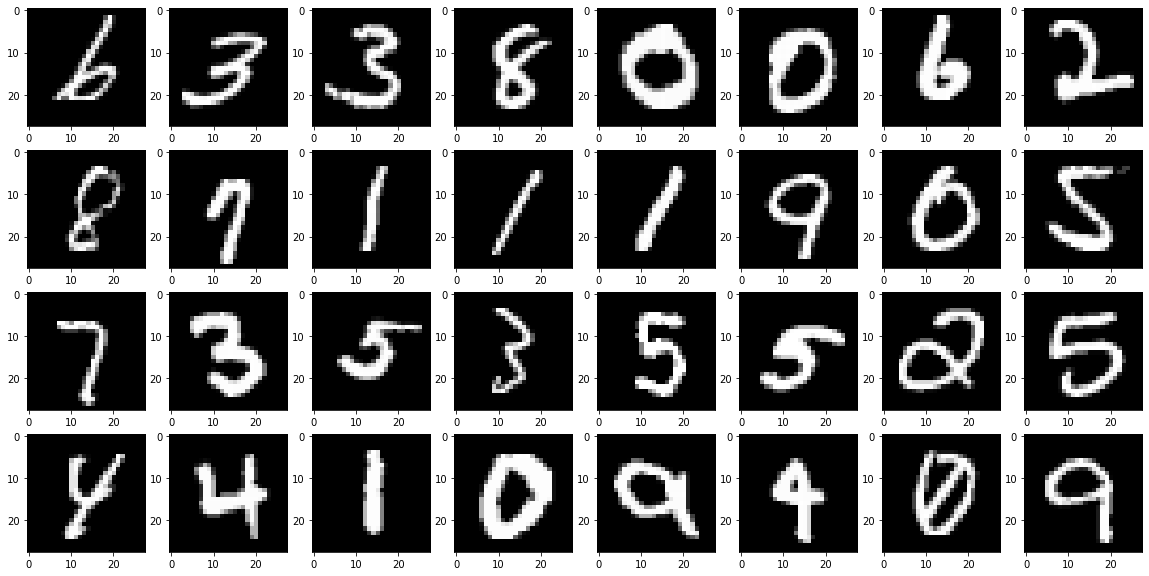

In [3]:
# check the load of mnist is correct 
print(train_data.shape)
# random visualize some samples 

VIS_ROWS = 4
VIS_COLS = 8
plt.rcParams['figure.figsize'] = [20, 10]

def visualize_images(img_array, selected, process = lambda x:x.reshape(*MNIST_IMG_SIZE)):
    k = 1
    fid = plt.figure()
    for i in range(VIS_ROWS):
        for j in range(VIS_COLS):
            plt.subplot(VIS_ROWS,VIS_COLS,k)
            plt.imshow(process(img_array[selected[k-1]]), cmap='gray' )
            k += 1

    plt.show()

selected = np.random.choice(train_data.shape[0], VIS_ROWS*VIS_COLS, replace = False)
visualize_images(train_data, selected)

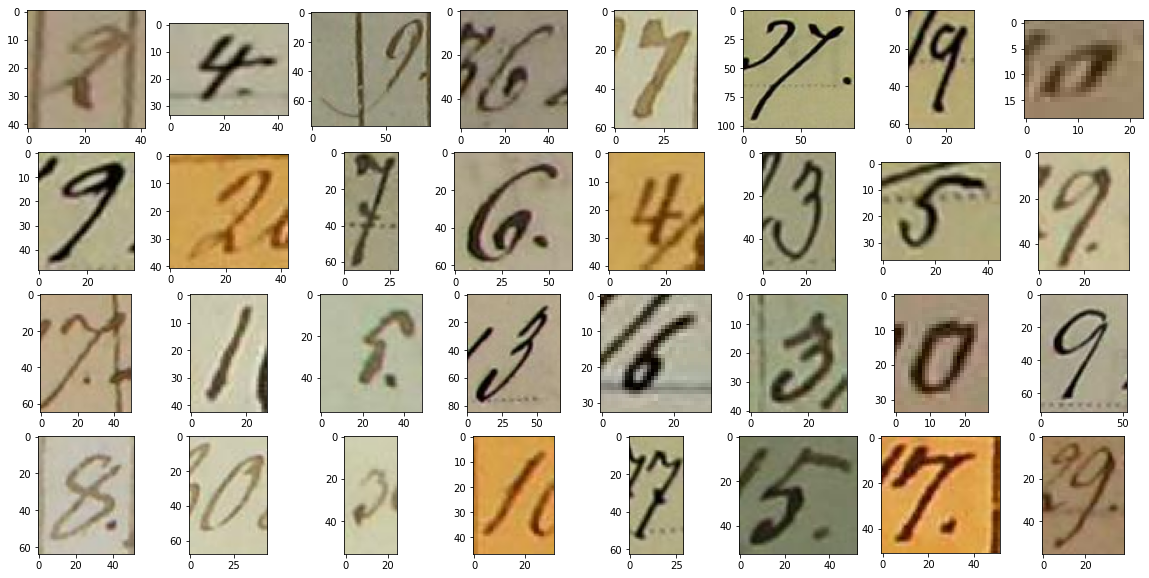

In [4]:
# this block process the dida digits dataset
PER_CLASS = 30
dida_dir = './data/digits/dida'
dida_images = []

for label in range(10):
    img_files = glob.glob(f'{dida_dir}/{label}/*.jpg')
    for i in range(PER_CLASS):
        dida_images.append( plt.imread(img_files[i]) )


# visualize 
selected = np.random.choice(len(dida_images), VIS_ROWS*VIS_COLS, replace = False)
visualize_images(dida_images, selected, process = lambda x:x)

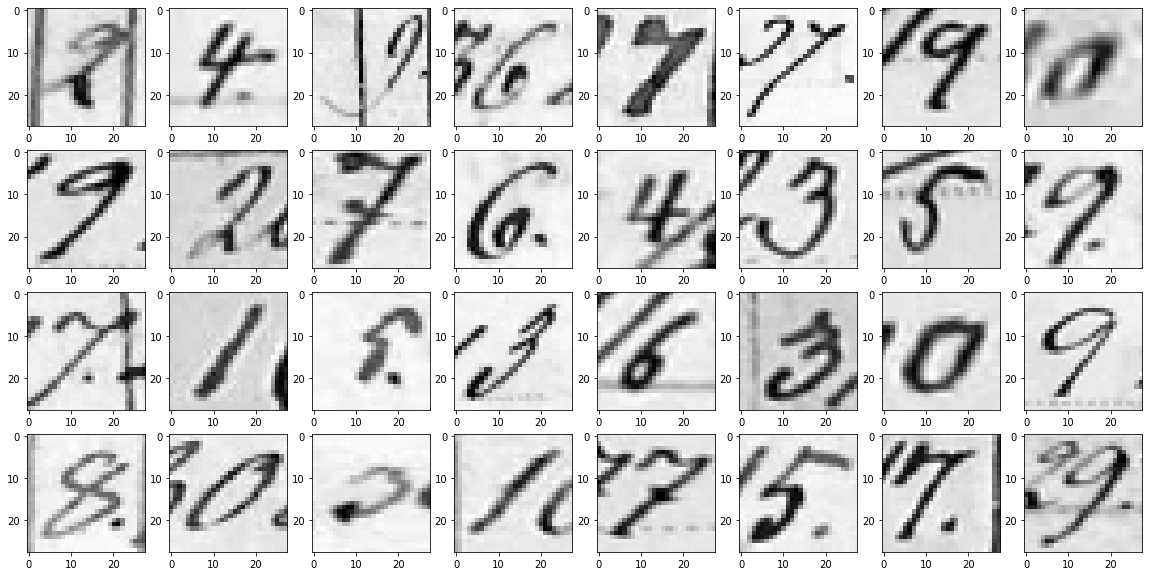

In [5]:
# convert dida images into mnist form (i.e, grey scale 28*28 image)
import cv2

def transform_to_mnist(img_rgb):
    img_gray = 0.21 * img_rgb[:,:,0] + 0.72 * img_rgb[:,:,1] + 0.07 * img_rgb[:,:,2]
    # img_gray = img_rgb.mean(axis=2)
    
    scaled_img = cv2.resize(img_gray, MNIST_IMG_SIZE , interpolation=cv2.INTER_AREA)
    assert(np.max(scaled_img) <= 255)
    scaled_img = scaled_img / MAX_VAL
    scaled_img = scaled_img.flatten()
    scaled_img = scaled_img.astype(np.float32)
    return scaled_img
    
# convert and visualize again
dida_img = np.array(list(map(transform_to_mnist, dida_images)))
visualize_images(dida_img, selected)

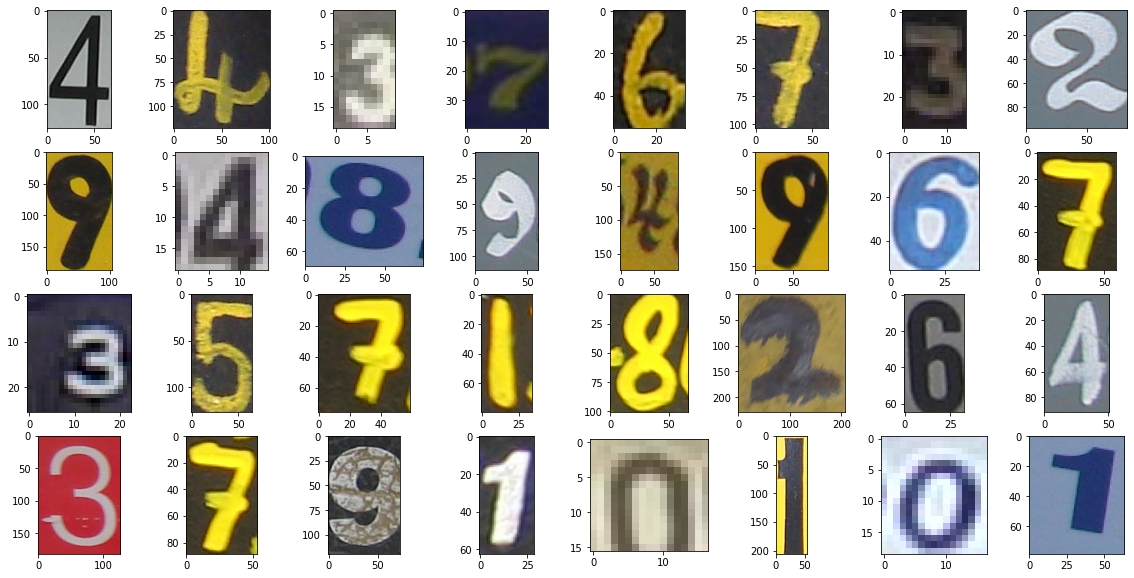

In [6]:
# this block process the chars74k dataset
ch74_dir = './data/digits/chars74k'
ch74_images = []
PER_CLASS = 30
for label in range(10):
    img_files = glob.glob('{}/Sample0{:02d}/*.png'.format(ch74_dir, label+1))
    for i in range(PER_CLASS):
        ch74_images.append( plt.imread(img_files[i]) )

# visualize 
selected = np.random.choice(len(ch74_images), VIS_ROWS*VIS_COLS, replace = False)
visualize_images(ch74_images, selected, process = lambda x:x)

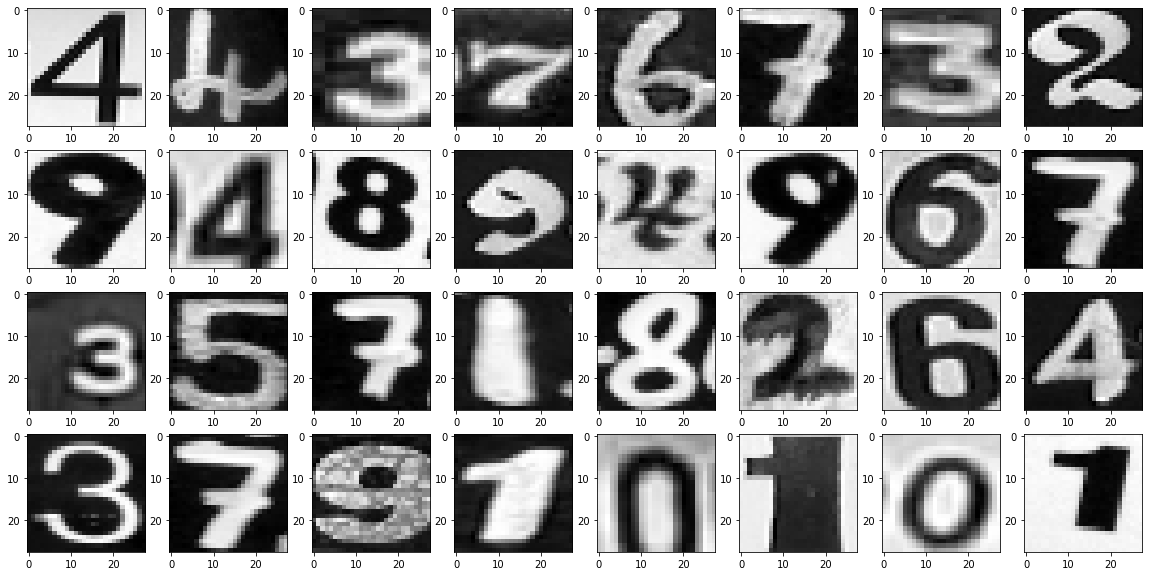

In [15]:
# convert char74 images into mnist form (i.e, grey scale 28*28 image) 

# convert and visualize again
# this dataset is already in 0-1
ch74_img = np.array(list(map(transform_to_mnist, ch74_images))) * MAX_VAL
visualize_images(ch74_img, selected)

In [8]:
# enhance the mnist data with reversed pixel color 
mnist_train = np.vstack([train_data, 1-train_data])
np.random.shuffle(mnist_train)
print(mnist_train.shape)

(140000, 784)


In [9]:
# train vanilla auto encoder
from autoencoder import AutoEncoder
from utmLib import utils
AE_SAVE_PATH = 'output/auto_encoder.pkl'
if os.path.exists(AE_SAVE_PATH):
    ae = utils.pkload(AE_SAVE_PATH)
else:
    ae = AutoEncoder(64, hsize = [1024,512,256,128], maxlr = 1e-3, batchsize = 512, wd = 0).fit(mnist_train)
    utils.pkdump(ae, AE_SAVE_PATH)

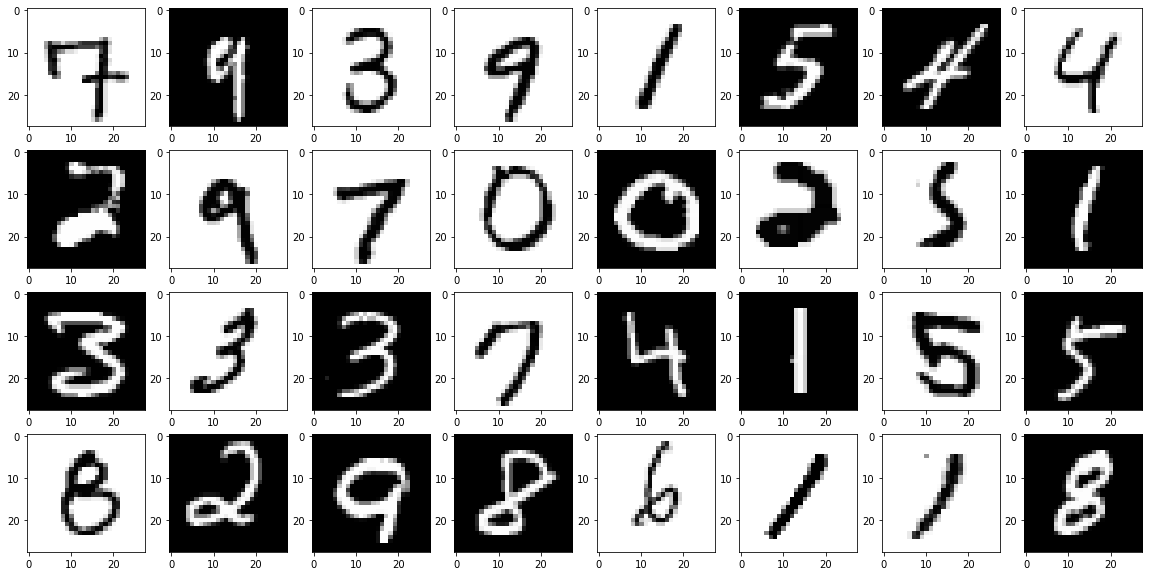

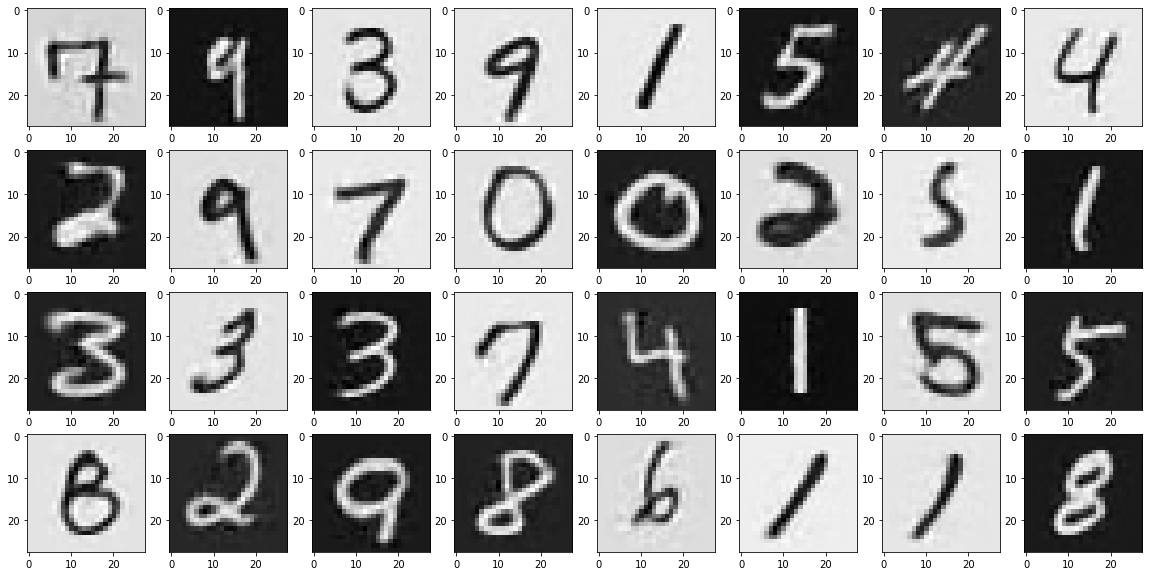

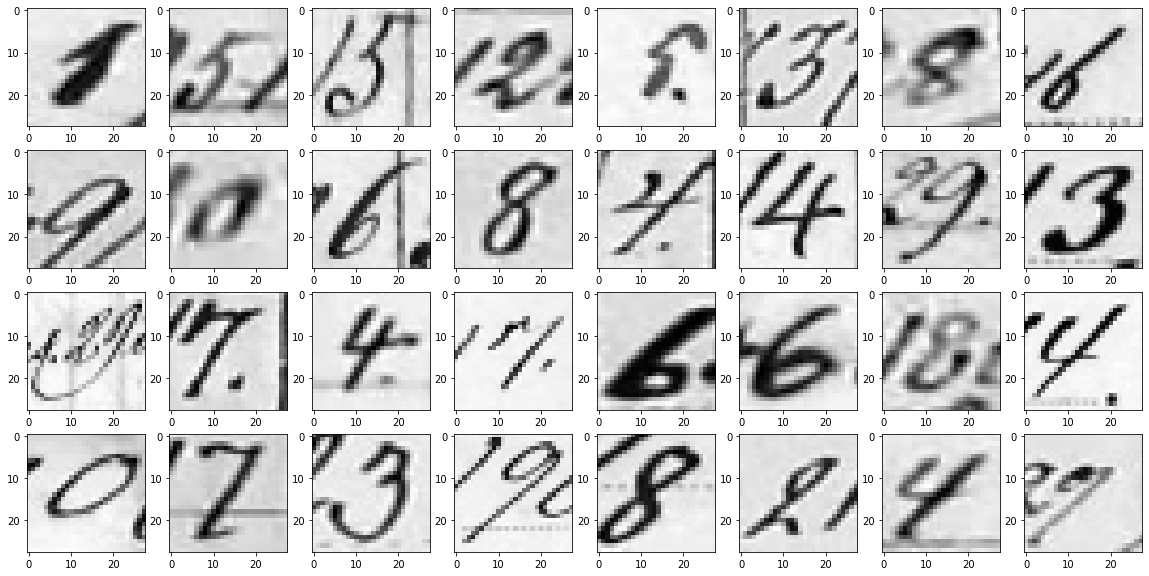

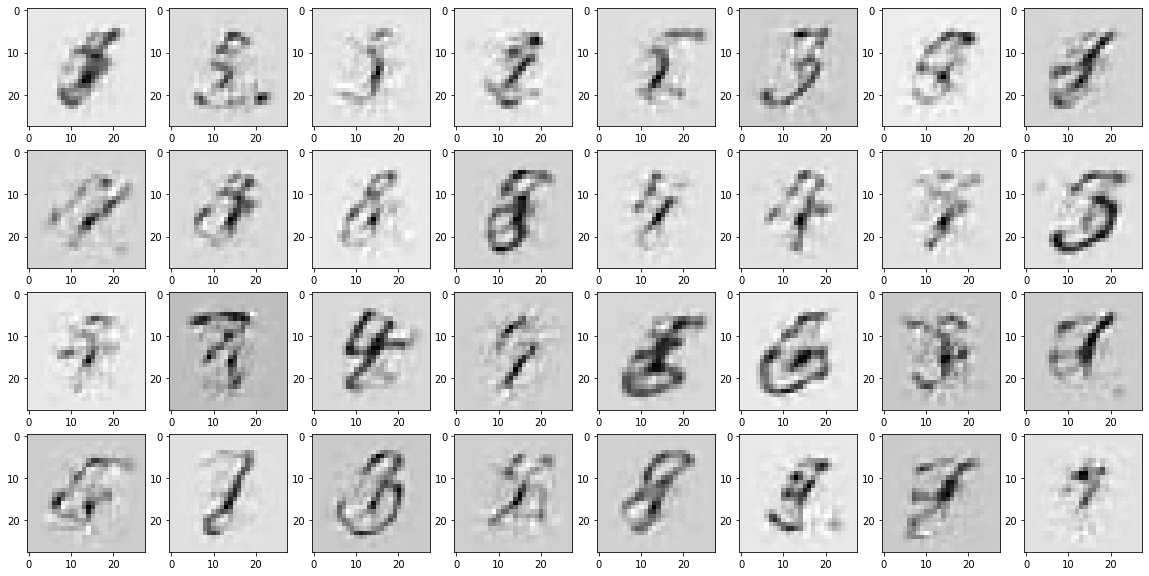

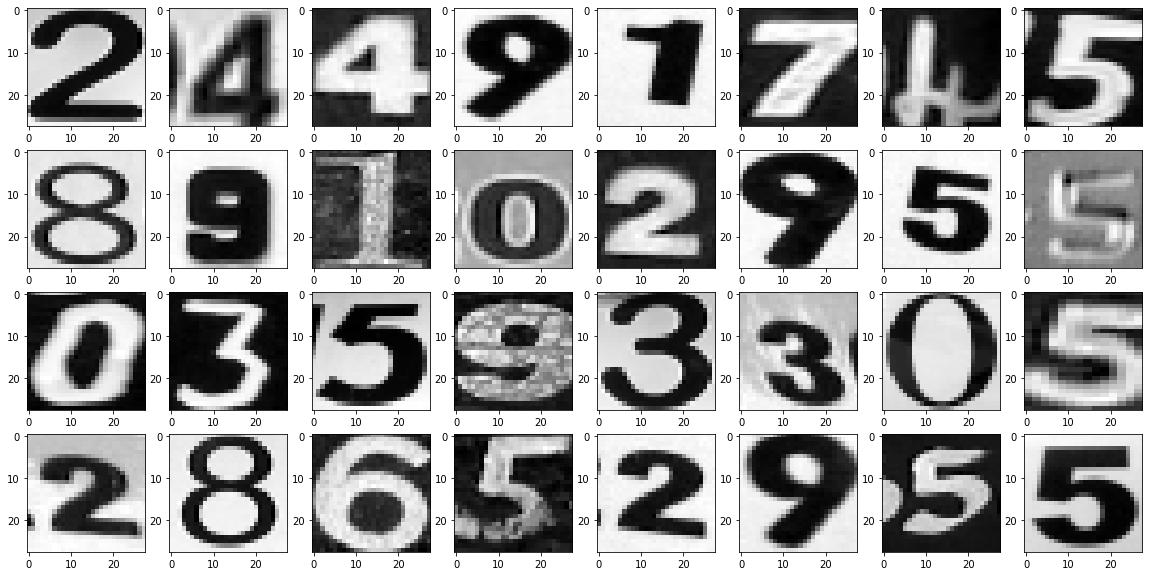

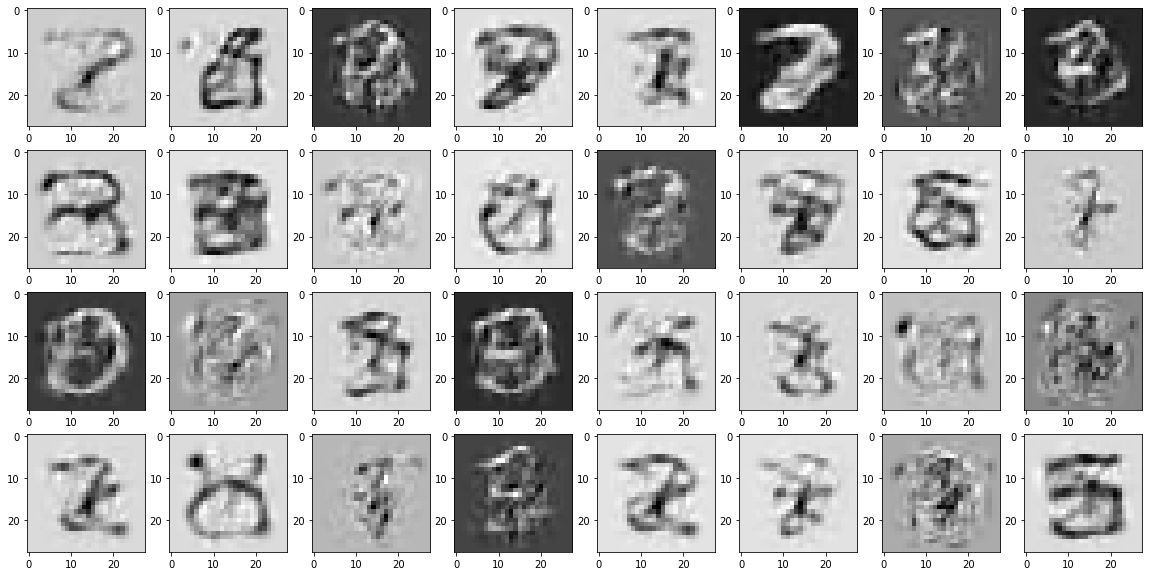

In [16]:
# test the quality of trained auto-encoder 
def test_projection(model, img_array):
    selected = np.random.choice(img_array.shape[0], VIS_ROWS*VIS_COLS, replace = False)
    visualize_images(img_array, selected)
    imgs = img_array[selected]
    F = model.transform(imgs)
    img_re = model.inverse_transform(F)
    visualize_images(img_re, np.arange(len(selected)) )

test_projection(ae, mnist_train)
test_projection(ae, dida_img)
test_projection(ae, ch74_img)